# The World Settlement Footprint (WSF)

* **Products used:** 
[wsf_2015](https://explorer.digitalearth.africa/products/wsf_2015), [wsf_2019](https://explorer.digitalearth.africa/products/wsf_2019)

## Background

According to the UN Department of Economics and Social Affairs, 9.7 billion people will inhabit the planet by the year 2050. 55% of the world's population presently resides in urban areas, and by 2050, that number is projected to increase to 68%. Rapid and haphazard urbanization, when paired with the problems posed by climate change, can increase air pollution, make people more susceptible to catastrophes, and cause problems with the management of resources like water, raw materials, and energy (Mapping Our Human Footprint From Space, n.d.).

To improve the understanding of current trends in global urbanisation, ESA and the German Aerospace Center (DLR), in collaboration with the Google Earth Engine team, are jointly developing the World Settlement Footprint – the world’s most comprehensive dataset on human settlement (Team, n.d.).

The **World Settlement Footprint 2015** is a 10m (0.32 arc sec) resolution binary mask outlining the 2015 global settlement extent derived by jointly exploiting multitemporal Sentinel-1 radar and Landsat-8 optical satellite imagery (Marconcini et al., 2020).

The **World Settlement Footprint 2019** features data from the Copernicus Sentinel-1 and Sentinel-2 missions and provides information on global human settlements with unprecedented detail and precision (Marconcini et al., 2021).


The World Settlement Footprint 2015 and 2019 data are now indexed in the DE Africa dataset.

## Description

This notebook is a walkthrough on how to use the World Settlement Footprint 2015 and 2019 in the data cube. The worked example takes users through the code required to:
 
   1. Inspecting the WSF data in the datacube
   2. Use `dc.load()` function to load in WSF data
   3. Plotting of results for WSF data

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline

import datacube
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image
from datacube.utils.geometry import Geometry

from deafrica_tools.plotting import display_map
from deafrica_tools.areaofinterest import define_area

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="wsf")

### List measurements

We can inspect the data available for WSF using datacube's `list_measurements` functionality. The table below lists the products and measurements available for the three WSF datasets indexed within DE Africa's datacube. 

In [3]:
product_name = ['wsf_2015', 'wsf_2019'] 

dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

,,name,dtype,units,nodata,aliases
product,measurement,,,,,
wsf_2015,wsf2015,wsf2015,uint8,1,0.0,[wsf2015]
wsf_2019,wsf2019,wsf2019,uint8,1,0.0,[wsf2019]


### Analysis parameters

To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

The default location is Kumasi, Ashanti Region, Ghana

In [4]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat= 6.69856, lon=-1.62331, buffer=0.2)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
#aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

# defining the color scheme for wfs 2015 and 2019 plotting
ft_2015 = '#D3D3D3'
ft_2019 = '#e5ab00'

### View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(x=lon_range, y=lat_range)

## Loading of the WSF Dataset

The WSF dataset will be loaded using the `dc.load` function. For more discussion on how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.

The cell below loads the wsf_2015 dataset. Notice the `product` and `measurements` values. 
These will be updated for the subsequent data when they are being loaded.

In [6]:
#create reusable datacube query object
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution':(-10, 10),
    'output_crs': 'epsg:6933',
}

#load the data and save it in wsf_2015 variable
wsf_2015 = dc.load(product='wsf_2015', measurements ='wsf2015', **query).squeeze()

#print out results
display(wsf_2015)

<xarray.Dataset>
Dimensions:      (y: 5070, x: 3860)
Coordinates:
    time         datetime64[ns] 2015-07-02T11:59:59.500000
  * y            (y) float64 8.78e+05 8.78e+05 8.78e+05 ... 8.273e+05 8.273e+05
  * x            (x) float64 -1.759e+05 -1.759e+05 ... -1.373e+05 -1.373e+05
    spatial_ref  int32 6933
Data variables:
    wsf2015      (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

The cell below loads the wsf_2019 dataset, notice the product and measurement is change
to `wsf_2019` and `wsf2019` respectively. Aside from that the query is the same as the previous query defined.

In [7]:
wsf_2019 = dc.load(product='wsf_2019', 
                 measurements='wsf2019', 
                 **query).squeeze()

display(wsf_2019)

<xarray.Dataset>
Dimensions:      (y: 5070, x: 3860)
Coordinates:
    time         datetime64[ns] 2019-07-02T11:59:59.500000
  * y            (y) float64 8.78e+05 8.78e+05 8.78e+05 ... 8.273e+05 8.273e+05
  * x            (x) float64 -1.759e+05 -1.759e+05 ... -1.373e+05 -1.373e+05
    spatial_ref  int32 6933
Data variables:
    wsf2019      (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## Spatial Plotting of data

The WSF dataset comes with two pixel values: `0` (no data) and `255` (settlement footprint). For the plot below, because we are interested in the settlement footprint so the dataset will be filtered to only include `255` values. After the filtering, the WSF datasets for 2015 and 2019 are plotted.

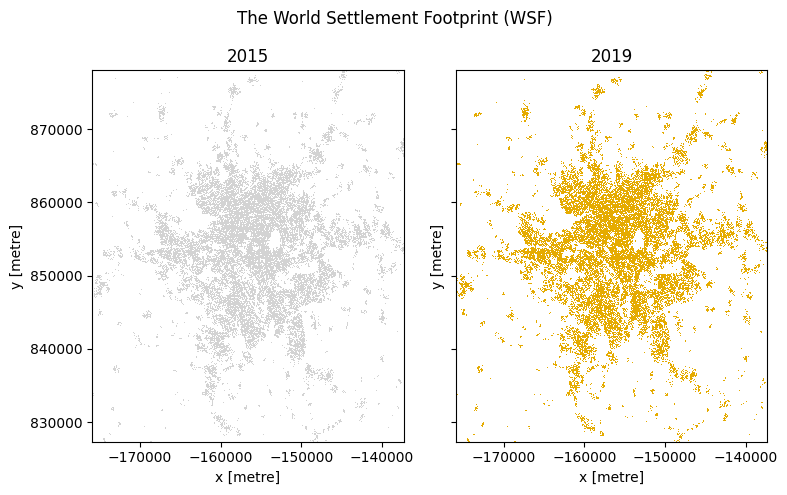

In [8]:
# storing datsets in the wsf_2015
wsf_2015 = wsf_2015.wsf2015

# storing datsets in the wsf_2019
wsf_2019 = wsf_2019.wsf2019

#Plotting of Dataset
fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

#filtering of the 2015 for only the 255 values
wsf_2015.where(wsf_2015 == 255).plot(ax=ax[0], add_colorbar=False,cmap=ListedColormap([ft_2015]))

#filtering of the 2019 for only the 255 values
wsf_2019.where(wsf_2015 == 255).plot(ax=ax[1], add_colorbar=False,cmap=ListedColormap([ft_2019]))
ax[0].set_title("2015")
ax[1].set_title("2019")
plt.suptitle('The World Settlement Footprint (WSF)')
plt.tight_layout()
plt.show();

### Calculate the area of the settlement footprint

The number of pixels can be used for the area of the building if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [9]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

The constant value `area_per_pixel` calculated above will be multiplied by the number of pixels to get the area of the building footprint for 2015 and 2019. The area will be plotted in a bar chart to compare the metric values across the evolution of buildings between the two years.

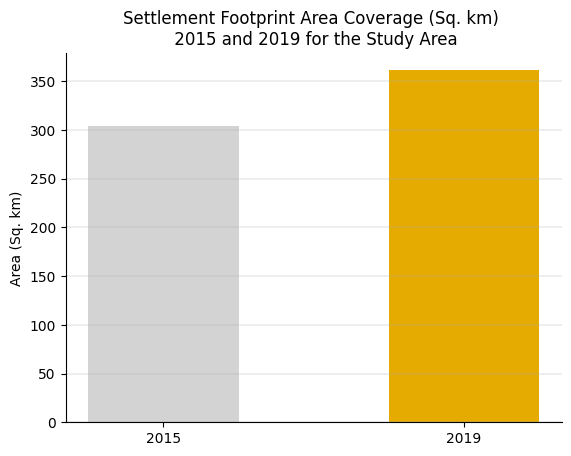

In [10]:
# Calculating the area for 2015
wsf_2015_area = wsf_2015.where(wsf_2015 == 255).count() * area_per_pixel

#Calculating the area for 2015
wsf_2019_area = wsf_2019.where(wsf_2019 == 255).count() * area_per_pixel

fig, ax = plt.subplots()
ax.bar(x = ['2015', '2019'], height = [wsf_2015_area, wsf_2019_area], 
       color=[ft_2015,ft_2019], width=0.5)
 
ax.set_ylabel("Area (Sq. km)")
ax.set_title(f"Settlement Footprint Area Coverage (Sq. km) \n 2015 and 2019 for the Study Area")
ax.grid(axis='y', linewidth=0.3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

### Plotting of Spatial Change
A bar graph aided in visualizing the comparison of the settlement area between 2015 and 2019, but a spatial plot will enable us to visualise the areas where there was development of settlements. To identify the areas that had an evolution between 2015 and 2019, 2015 will serve as the baseline against 2019. The difference will be plotted to determine the area of change.

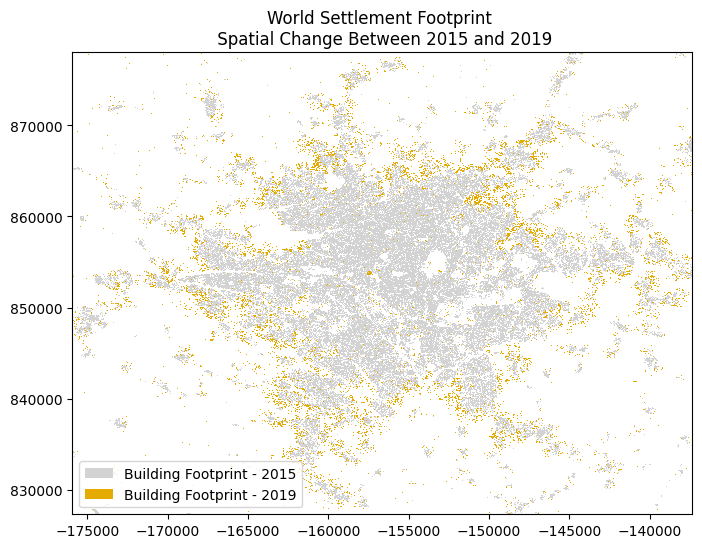

In [11]:
wsf_change =  wsf_2015.where(wsf_2015 == 255, 0) - wsf_2019.where(wsf_2019 == 255, 0)

wsf_2015.where(wsf_2015 == 255).plot.imshow(cmap=ListedColormap([ft_2015]), 
                                               add_colorbar=False, add_labels=False, 
                                               figsize=(8,6))
                             
wsf_change.where(wsf_change == 1).plot.imshow(cmap=ListedColormap([ft_2019]), 
                           add_colorbar=False, add_labels=False)

plt.legend(
        [Patch(facecolor=ft_2015), Patch(facecolor=ft_2019)],
        ['Building Footprint - 2015', 'Building Footprint - 2019'],
         loc = 'lower left');

plt.title('World Settlement Footprint \n Spatial Change Between 2015 and 2019');

plt.show()

### Conclusion

The World Settlement Footprint offers a knowledge base that can help researchers, governmental organizations, and other stakeholders, such as urban planners, better understand how urbanization is happening and, concurrently, put in place sustainable urban development strategies for informed policy decisions at local and national levels.


**Note**

To run for different area go to cell **Analysis parameters**, change the **lat** and **lon** values in the **define_area_function**.

#### Referencing

Mapping our human footprint from space. (n.d.). ESA - Mapping Our Human Footprint From Space. https://www.esa.int/Applications/Observing_the_Earth/Mapping_our_human_footprint_from_space

Marconcini, M., Metz-Marconcini, A., Üreyen, S. et al. Outlining where humans live, the World Settlement Footprint 2015. Sci Data 7, 242 (2020). https://doi.org/10.1038/s41597-020-00580-5

Mattia Marconcini, Annekatrin Metz-Marconcini, Thomas Esch and Noel Gorelick. Understanding Current Trends in Global Urbanisation - The World Settlement Footprint Suite. GI_Forum 2021, Issue 1, 33-38 (2021) https://austriaca.at/0xc1aa5576%200x003c9b4c.pdf

Team, G. D. (n.d.). EOC Geoservice Map Contexts. EOC Geoservice Map Contexts. https://geoservice.dlr.de/web/maps

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [12]:
print(datacube.__version__)

1.8.15


**Last tested:**

In [13]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-08-24'